In [1]:
import pandas as pd
import numpy as np
import seaborn as sns





import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("medquad.csv")
df = df.dropna()

#df = df.sample(2000)
#df = df.reset_index()
#df = df.drop('index',axis =1)
display(df.shape)
df.head()

(16393, 4)

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


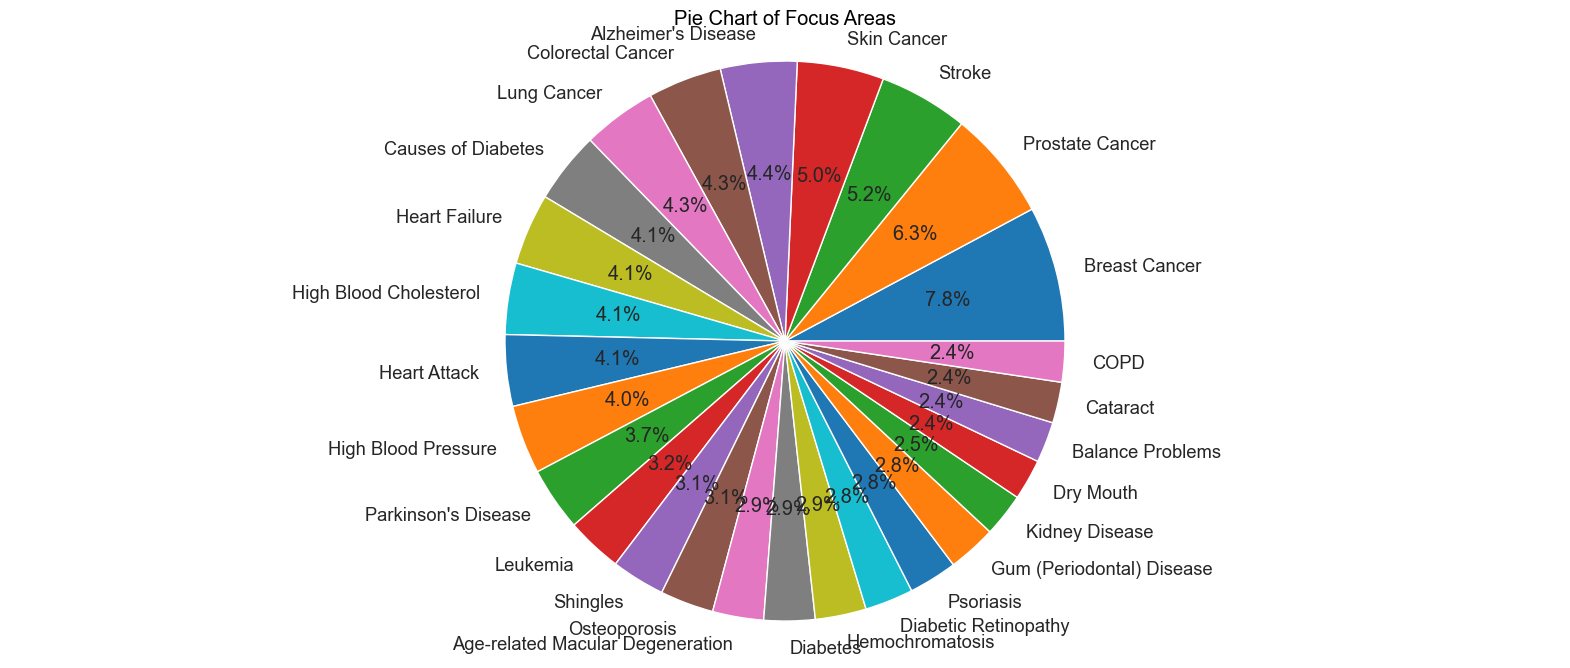

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your input DataFrame
focus_area_counts = df['focus_area'].value_counts()
focus_areas = focus_area_counts[focus_area_counts > 15].index

fig, ax = plt.subplots(figsize=(20, 8))
sns.set(font_scale=1.2)

ax.pie(focus_area_counts[focus_areas], labels=focus_areas, autopct='%1.1f%%')
ax.set_title('Pie Chart of Focus Areas')
ax.axis('equal')  # Equal aspect ratio ensures that pie is circular.

plt.show()

In [4]:
import random


# ANSI color codes

color_codes = {

    "blue": 34,
    "green": 32,
    "red": 31,
    "purple": 35,
    "orange": 33,
    "yellow": 33,
    "pink": 35,
    "brown": 33,
    "gray": 37
}



for i in range(0, len(df), 7):

    color = random.choice(list(color_codes.values()))

    print(f"\033[1;{color}mThe question is: {df['question'][i]}\033[0m\n\033[1;{color}m The answer is: {df['answer'][i]}\033[0m\n")

    if i > 30:

        break

The question is: What is (are) Glaucoma ?
 The answer is: Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As the fluid builds up, the pressure inside the eye rises. Unless this pressure is controlled, it may cause damage to the optic nerve and other parts of the eye and result in loss of visio

In [5]:
!pip install transformers sentence-transformers faiss-cpu

In [6]:
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer

# Question Encoder (for retrieving documents)
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

# Context Encoder (for encoding the documents in the knowledge base)
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the

In [7]:
!pip install tf-keras
from transformers import BartForConditionalGeneration, BartTokenizer
from sentence_transformers import SentenceTransformer
import torch

# Generator model
generator = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
generator_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [8]:
unique_focus_areas = df['focus_area'].unique()

# Filter for focus areas with more than 50 occurrences
filtered_focus_areas = df['focus_area'].value_counts()[df['focus_area'].value_counts() > 15]


# Get the top 1000
selected_focus_areas = filtered_focus_areas.head(1000)

# Print the selected focus areas
selected_focus_areas

new_df = pd.DataFrame()

for focus_area in selected_focus_areas.index:
    # Filter the original DataFrame for the current focus area
    focus_area_df = df[df['focus_area'] == focus_area]

    # Sample 20 rows from the filtered DataFrame
    sampled_df = focus_area_df.sample(n=min(20, len(focus_area_df))) # Ensure we don't try to sample more than exist

    # Concatenate the sampled rows to the new DataFrame
    new_df = pd.concat([new_df, sampled_df])

# Now 'new_df' contains up to 20 samples from each of the selected focus areas.
display(new_df.shape)

new_df.head()

(518, 4)

,question,answer,source,focus_area
407,What are the treatments for Breast Cancer ?,Certain drugs that have been used successfully...,NIHSeniorHealth,Breast Cancer
402,What is (are) Breast Cancer ?,There are two types of breast-conserving surge...,NIHSeniorHealth,Breast Cancer
381,Who is at risk for Breast Cancer? ?,Some women develop breast cancer and others do...,NIHSeniorHealth,Breast Cancer
775,What are the treatments for Breast Cancer ?,Key Points\n - Treatment op...,CancerGov,Breast Cancer
770,Who is at risk for Breast Cancer? ?,Sometimes breast cancer occurs in women who ar...,CancerGov,Breast Cancer


In [9]:
 encoded_docs = []
for index, row in new_df.iterrows():

    inputs = context_tokenizer(row['answer'], return_tensors='pt', truncation=True, max_length=512)

    with torch.no_grad():

        doc_embedding = context_encoder(**inputs).pooler_output

    encoded_docs.append(doc_embedding.numpy())

In [10]:
import faiss

import numpy as np



encoded_docs = np.array([embedding.reshape(1,-1) for embedding in encoded_docs]) # Reshape each embedding to (1, embedding_dimension)

encoded_docs = np.vstack(encoded_docs) # Stack the reshaped embeddings into a single array



# Now proceed with indexing

dimension = encoded_docs.shape[1]  # Get the embedding dimension

index = faiss.IndexFlatIP(dimension)  # Using Inner Product (dot-product) for similarity

index.add(encoded_docs)

# Retrieval-Augmented Generation (RAG) 

Retrieval-Augmented Generation (RAG) is a technique that combines the strengths of large language models (LLMs) with the power of information retrieval to produce more accurate, relevant, and informative responses to user queries.

![](https://global.discourse-cdn.com/openai1/original/4X/8/f/f/8ffadd37d90228cdbded952f027d75155fb69391.jpeg)
   
## How RAG Works:

- **Query Understanding:** The LLM first processes the user's query to understand its intent and meaning.
- **Document Retrieval:** Based on the query, a document retrieval system searches a knowledge base or external data source to find relevant information.   
- **Contextual Augmentation:** The retrieved information is then integrated with the original query to create a more comprehensive context for the LLM.   
- **Response Generation:** The LLM uses the augmented context to generate a response that is more accurate, relevant, and informative than it would be without the additional information.


## Benefits of RAG:

- **Improved Accuracy:** RAG helps LLMs access and incorporate factual information, reducing the likelihood of hallucinations or generating incorrect responses.   
- **Enhanced Relevance:** By retrieving relevant information, RAG ensures that the LLM's responses are directly related to the user's query.   
- **Increased Informativeness:** RAG allows LLMs to provide more detailed and comprehensive responses by leveraging external knowledge sources.   
- **Adaptability:** RAG can be applied to various domains and industries, making it a versatile tool for many applications.

## Use Cases of RAG:

- **Customer Service Chatbots:** RAG-powered chatbots can access a knowledge base of product information, FAQs, and customer support guidelines to provide accurate and helpful responses.   
- **Search Engines:** RAG can enhance search engine results by providing more relevant and informative summaries of web pages.   
- **Content Creation:** RAG can assist in content creation by suggesting relevant facts, statistics, and citations.   
- **Healthcare:** RAG can help doctors and researchers access and analyze medical literature to improve diagnosis and treatment.

 
## Challenges and Considerations:

- **Data Quality:** The quality of the retrieved information is crucial for the effectiveness of RAG. It's important to ensure that the knowledge base is accurate, up-to-date, and relevant.
- **Model Bias:** LLMs can inherit biases from the data they are trained on. It's important to be aware of these biases and take steps to mitigate them.   
- **Computational Cost:** RAG can be computationally expensive, especially when dealing with large knowledge bases and complex queries.
- **Privacy Concerns:** When accessing and processing sensitive information, it's important to consider privacy implications and implement appropriate safeguards.

Overall, RAG is a powerful technique that has the potential to significantly improve the capabilities of LLMs. By combining the strengths of both retrieval and generation, RAG can help create more intelligent and informative AI systems

In [12]:
%%time


def rag(query):

    # Tokenize the question

    question_inputs = question_tokenizer(query, return_tensors='pt')

    with torch.no_grad():

        # Embeddings

        question_embedding = question_encoder(**question_inputs).pooler_output.numpy()

    # Retrieve indexes of top 2 documents

    top_k = 2

    _, indices = index.search(question_embedding, top_k)

    retrieved_docs = [new_df['answer'].iloc[idx] for idx in indices[0]] # Use new_df and iloc

    # Concatenate retrieved documents with the query as input for the generator

    context = " ".join(retrieved_docs)

    input_text = query + " " + context

    # Generate a response using the generator model

    inputs = generator_tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)

    output_ids = generator.generate(**inputs, max_length=20, num_beams=5, early_stopping=True)

    answer = generator_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return answer

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
new_df['focus_area'].value_counts()

focus_area
Breast Cancer                       20
Heart Attack                        20
Hemochromatosis                     20
Diabetes                            20
Age-related Macular Degeneration    20
Osteoporosis                        20
Shingles                            20
Prostate Cancer                     20
Parkinson's Disease                 20
High Blood Pressure                 20
Leukemia                            20
High Blood Cholesterol              20
Heart Failure                       20
Causes of Diabetes                  20
Lung Cancer                         20
Colorectal Cancer                   20
Alzheimer's Disease                 20
Skin Cancer                         20
Stroke                              20
Diabetic Retinopathy                19
Psoriasis                           19
Gum (Periodontal) Disease           19
Kidney Disease                      17
Dry Mouth                           16
Balance Problems                    16
Cataract      

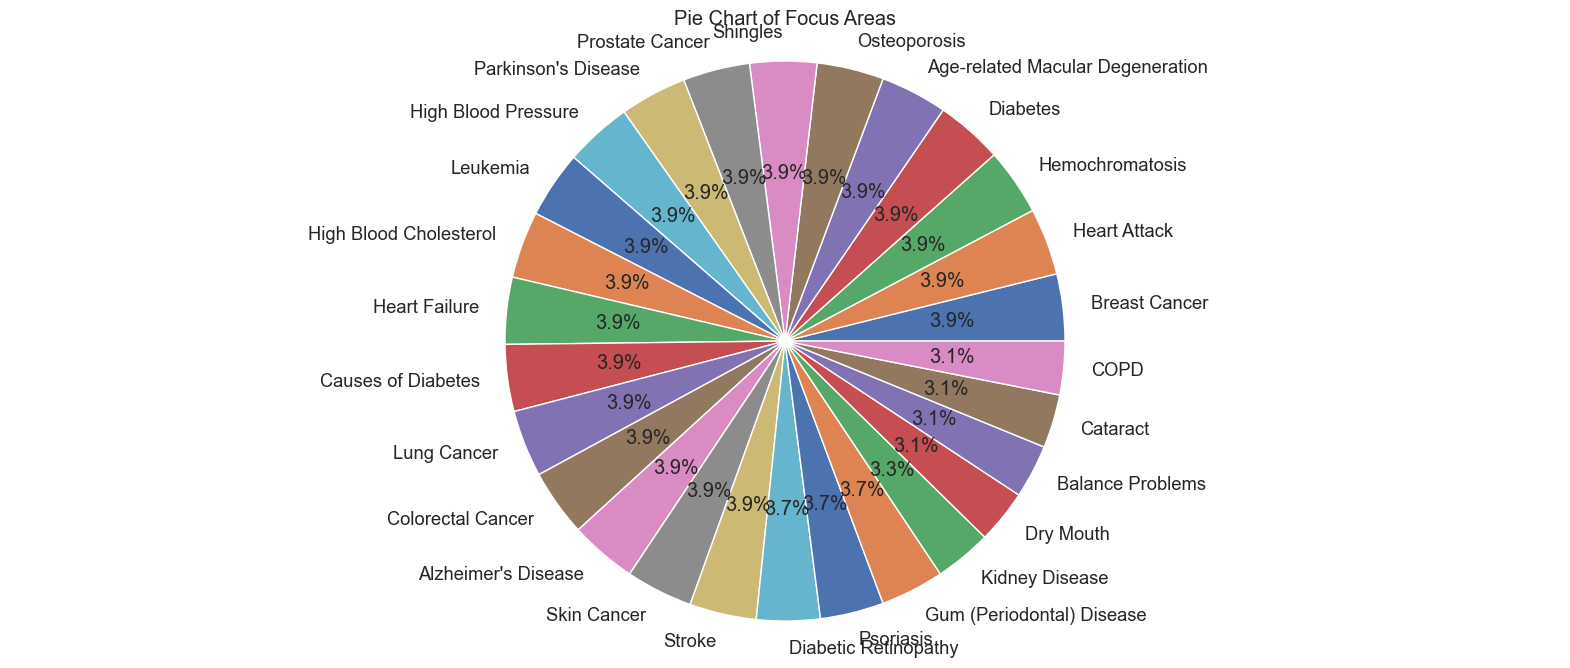

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your input DataFrame
focus_area_counts =new_df['focus_area'].value_counts()
focus_areas = focus_area_counts[focus_area_counts > 15].index

fig, ax = plt.subplots(figsize=(20, 8))
sns.set(font_scale=1.2)

ax.pie(focus_area_counts[focus_areas], labels=focus_areas, autopct='%1.1f%%')
ax.set_title('Pie Chart of Focus Areas')
ax.axis('equal')  # Equal aspect ratio ensures that pie is circular.

plt.show()

In [15]:
query = "What is the Breast Cancer?"

response = rag(query)

print("Question:", query)
print("Response:", response)

Question: What is the Breast Cancer?
Response: Breast cancer occurs when a malignant tumor forms in the breast tissue. It occurs


In [16]:
query = "What is COPD?"

response = rag(query)

print("Question:", query)
print("Response:", response)

Question: What is COPD?
Response: COPD (chronic obstructive pulmonary disease) makes it hard for you to


In [38]:
query = "What is Osteoporosis?"

response = rag(query)

print("Question:", query)
print("Response:", response)

Question: What is Osteoporosis?
Response: Osteoporosis is a disease that thins and weakens the bones.


In [19]:
query = "What is High Blood Pressure?"

response = rag(query)


print(f"\033[1;31mQuestion:\033[0m \033[1;36m{query}\033[0m")
print(f"\033[1;31mResponse:\033[0m \033[1;36m{response}\033[0m")

Question: What is High Blood Pressure?
Response: High blood pressure is a common disease in which blood flows through blood vessels at higher than


In [96]:
import gradio as gr
from transformers import pipeline

In [98]:
question_answerer = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

In [100]:
def question_answer(text, question):
    result = question_answerer(question=question, context=text)
    return question, result['answer'], result['score'], result['start'], result['end']

In [105]:
app = gr.Interface(
    fn=question_answer,
    inputs = [
        gr.Textbox(label="Paste the text to search."), 
        gr.Textbox(label="Ask a question.")],
    outputs=gr.Textbox(lines=10, label="Answer to question, probability score, and location.", show_copy_button=True))

In [102]:
app.launch()

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----

To create a public link, set `share=True` in `launch()`.
